In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class QLearningPathPlanner:
    def __init__(self,
                 curr_map: np.ndarray,
                 start_point: tuple,
                 goal_point: tuple,
                 episodes=1000,
                 epsilon=0.9,
                 discount_factor=0.9,
                 learning_rate=0.9,
                 straight_move_reward=-1,
                 diagonal_move_reward=-(2**0.5),
                 goal_distance_reward=1,
                 obstacle_hit_reward=-100,
                 goal_reach_reward=100,
                 bound_hit_reward=-50):
        self.curr_map = curr_map.copy()
        self.start_point = np.array(start_point)
        self.curr_point = np.array(start_point)
        self.prev_point = np.array(start_point)
        self.goal_point = np.array(goal_point)
        self.episodes = episodes
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.straight_move_reward = straight_move_reward
        self.diagonal_move_reward = diagonal_move_reward
        self.goal_distance_reward = goal_distance_reward
        self.obstacle_hit_reward = obstacle_hit_reward
        self.goal_reach_reward = goal_reach_reward
        self.bound_hit_reward = bound_hit_reward
        num_rows, num_columns = curr_map.shape
        self.q_table = np.zeros((num_rows+2, num_columns+2, 8))
        self.num_rows, self.num_columns = num_rows, num_columns
        self.actions = {
            0: np.array((-1, -1)),
            1: np.array((-1, 0)),
            2: np.array((-1, 1)),
            3: np.array((0, -1)),
            4: np.array((0, 1)),
            5: np.array((1, -1)),
            6: np.array((1, 0)),
            7: np.array((1, 1))
        }
        self.prev_action = 0
        self.move_distance = 0
        self.status = None
        self.is_out_of_bounds = False
        self.first_goal_reached = None
        self.episode = 0

    def reset_state(self):
        self.curr_point = self.start_point
        self.prev_point = self.start_point
        self.prev_action = 0
        self.move_distance = 0
        self.status = None

    def take_next_step(self):
        curr_point = self.curr_point
        if np.random.random() < self.epsilon:
            curr_action = np.argmax(self.q_table[curr_point[1]+1, curr_point[0]+1])
        else:
            curr_action = np.random.randint(8)
        next_point = curr_point + self.actions[curr_action]
        move_distance = np.sqrt(self.actions[curr_action][0] ** 2 + self.actions[curr_action][1] ** 2)
        self.move_distance = move_distance
        self.prev_point = curr_point
        self.curr_point = next_point
        self.prev_action = curr_action

    def get_reward(self):
        curr_map = self.curr_map
        curr_point = self.curr_point
        prev_point = self.prev_point
        goal_point = self.goal_point
        curr_reward = 0

        if self.move_distance == 1:
            curr_reward += self.straight_move_reward
        elif self.move_distance > 1:
            curr_reward += self.diagonal_move_reward
        
        prev_goal_distance = np.sqrt((prev_point[0] - goal_point[0])**2 + (prev_point[1] - goal_point[1])**2)
        curr_goal_distance = np.sqrt((curr_point[0] - goal_point[0])**2 + (curr_point[1] - goal_point[1])**2)
        goal_distance_diff = prev_goal_distance - curr_goal_distance
        curr_reward += (self.goal_distance_reward * goal_distance_diff)

        if curr_point[1] >= self.num_rows or curr_point[1] < 0 or curr_point[0] >= self.num_columns or curr_point[0] < 0:
            curr_reward += self.bound_hit_reward
        elif curr_map[curr_point[1], curr_point[0]] == 0:
            curr_reward += self.obstacle_hit_reward
        elif curr_point[0] == goal_point[0] and curr_point[1] == goal_point[1]:
            curr_reward += self.goal_reach_reward

        return curr_reward

    def curr_is_terminal(self):
        curr_map = self.curr_map
        curr_point = self.curr_point
        goal_point = self.goal_point
        if curr_point[1] >= self.num_rows or curr_point[1] < 0 or curr_point[0] >= self.num_columns or curr_point[0] < 0:
            self.status = "Fell of the map"
            return True
        if curr_map[curr_point[1], curr_point[0]] == 0:
            self.status = "Hit obstacle"
            return True
        if curr_point[0] == goal_point[0] and curr_point[1] == goal_point[1]:
            self.status = "Reached goal!"
            if self.first_goal_reached is None:
                self.first_goal_reached = self.episode
            return True
        return False

    def train(self):
        for episode in range(self.episodes):
            self.episode = episode
            self.reset_state()
            while not self.curr_is_terminal():
                self.take_next_step()
                curr_reward = self.get_reward()
                prev_point = self.prev_point
                curr_point = self.curr_point
                prev_action = self.prev_action
                prev_q_value = self.q_table[prev_point[1]+1, prev_point[0]+1, prev_action]
                temporal_difference = (
                    curr_reward +
                    (self.discount_factor * np.max(self.q_table[curr_point[1]+1, curr_point[0]+1])) -
                    prev_q_value
                )
                curr_q_value = prev_q_value + self.learning_rate * temporal_difference
                self.q_table[prev_point[1]+1, prev_point[0]+1, prev_action] = curr_q_value
    
    def get_path(self):
        self.reset_state()
        path = [self.start_point]
        epsilon = self.epsilon
        self.epsilon = 1
        while self.curr_point[0] != self.goal_point[0] or self.curr_point[1] != self.goal_point[1]:
            self.take_next_step()
            path.append(self.curr_point)
        return np.array(path)

In [3]:
def get_core_points(path):
    curr_point = path[0]
    next_point = path[1]
    prev_slope = (next_point[1] - curr_point[1]) / (next_point[0] - curr_point[0])
    core_points = list()
    for i in range(1, path.shape[0]-1):
        curr_point = path[i]
        next_point = path[i+1]
        curr_slope = (next_point[1] - curr_point[1]) / (next_point[0] - curr_point[0])
        if curr_slope != prev_slope:
            core_points.append(curr_point)
        prev_slope = curr_slope
    return np.array(core_points)

In [4]:
curr_map = np.full((11, 11), 0)

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#set the curr_map for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    curr_map[row_index, column_index] = 255

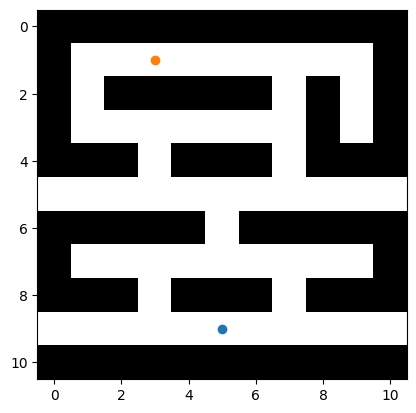

In [5]:
plt.imshow(curr_map, cmap='gray')
start = (5, 9)
end = (3, 1)
plt.scatter(start[0], start[1])
plt.scatter(end[0], end[1])
plt.show()

In [6]:
q_planner = QLearningPathPlanner(
        curr_map,
        start,
        end
    )
q_planner.train()

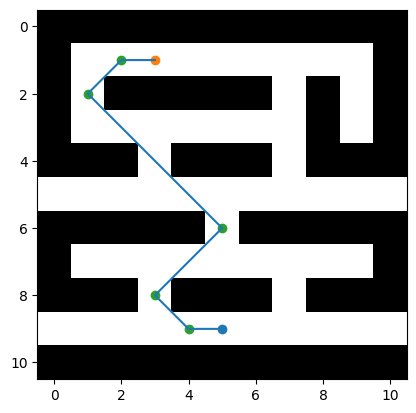

In [9]:
path = q_planner.get_path()
core_points = get_core_points(path)
plt.imshow(curr_map, cmap='gray')
plt.plot(path[:, 0], path[:, 1])
plt.scatter(start[0], start[1])
plt.scatter(end[0], end[1])
plt.scatter(core_points[:, 0], core_points[:, 1])
plt.show()